# Practical Session on Graph Neural Networks

**by Matthieu Nastorg**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [ ]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/ 
#####################################################
import torch 

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 48.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.7/874.7 KB 16.3

### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [ ]:
#####################################################
################## PACKAGES #########################
#####################################################
import torch 
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [ ]:
### LOAD DATASETS

BATCH_SIZE = 2 

# Train Dataset
train_dataset = PPI(root="", split='train')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [ ]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [ ]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []
    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)
    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [ ]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [ ]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(  input_size = n_features, 
                                hidden_size = 256, 
                                output_size = n_classes).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(basic_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)



Device:  cuda
Epoch 00001 | Loss: 0.6363
F1-Score: 0.4364
Epoch 00002 | Loss: 0.5820
Epoch 00003 | Loss: 0.5623
Epoch 00004 | Loss: 0.5563
Epoch 00005 | Loss: 0.5510
Epoch 00006 | Loss: 0.5458
F1-Score: 0.4863
Epoch 00007 | Loss: 0.5412
Epoch 00008 | Loss: 0.5370
Epoch 00009 | Loss: 0.5337
Epoch 00010 | Loss: 0.5310
Epoch 00011 | Loss: 0.5282
F1-Score: 0.5271
Epoch 00012 | Loss: 0.5255
Epoch 00013 | Loss: 0.5230
Epoch 00014 | Loss: 0.5206
Epoch 00015 | Loss: 0.5183
Epoch 00016 | Loss: 0.5160
F1-Score: 0.5356
Epoch 00017 | Loss: 0.5138
Epoch 00018 | Loss: 0.5117
Epoch 00019 | Loss: 0.5097
Epoch 00020 | Loss: 0.5077
Epoch 00021 | Loss: 0.5059
F1-Score: 0.5238
Epoch 00022 | Loss: 0.5041
Epoch 00023 | Loss: 0.5024
Epoch 00024 | Loss: 0.5003
Epoch 00025 | Loss: 0.4981
Epoch 00026 | Loss: 0.4962
F1-Score: 0.5321
Epoch 00027 | Loss: 0.4947
Epoch 00028 | Loss: 0.4929
Epoch 00029 | Loss: 0.4910
Epoch 00030 | Loss: 0.4891
Epoch 00031 | Loss: 0.4871
F1-Score: 0.5464
Epoch 00032 | Loss: 0.4852
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6026


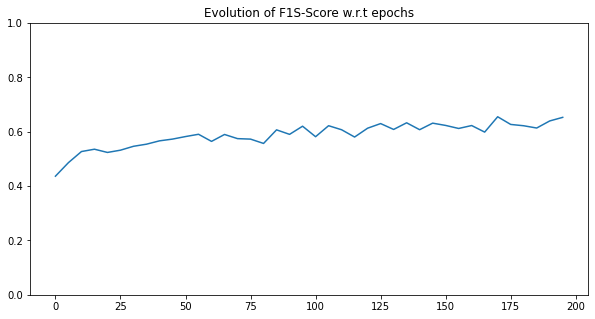

In [ ]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))

### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores) :
    plt.figure(figsize=[10,5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [ ]:
class StudentModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
      super().__init__()
      self.GATconv_1 = graphnn.GATConv(input_size,hidden_size,heads=4)
      self.GATconv_2 = graphnn.GATConv(hidden_size*4,hidden_size,heads=4)
      self.GATconv_3 = graphnn.GATConv(hidden_size*4,output_size,heads=6,concat=False)
      self.elu = nn.ELU()
      
  def forward(self, x, edge_index):
    out_nodes= self.elu(self.GATconv_1(x,edge_index))
    out_nodes = self.elu(self.GATconv_2(out_nodes,edge_index)+out_nodes)
    out_nodes = self.GATconv_3(out_nodes,edge_index)

    return out_nodes

Let's train your model !

In [ ]:
def train_auto(model, loss_fcn, device, optimizer, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []
    best_F1 = 0
    patience = 0
    epoch=0
    # while the score is increasing
    while True :
        patience +=1
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch+1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            if score>best_F1:
              best_F1 = score
              patience = 0

            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)
        if patience>100:
          break
        epoch+=1
    return epoch_list, scores_list

In [ ]:
## Student model
student_model = StudentModel(n_features,256,n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train_auto(student_model, loss_fcn, device, optimizer, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.7227
F1-Score: 0.4096
Epoch 00002 | Loss: 0.5611
Epoch 00003 | Loss: 0.5414
Epoch 00004 | Loss: 0.5318
Epoch 00005 | Loss: 0.5165
Epoch 00006 | Loss: 0.5066
F1-Score: 0.4944
Epoch 00007 | Loss: 0.4955
Epoch 00008 | Loss: 0.4887
Epoch 00009 | Loss: 0.4799
Epoch 00010 | Loss: 0.4735
Epoch 00011 | Loss: 0.4665
F1-Score: 0.5868
Epoch 00012 | Loss: 0.4587
Epoch 00013 | Loss: 0.4542
Epoch 00014 | Loss: 0.4523
Epoch 00015 | Loss: 0.4417
Epoch 00016 | Loss: 0.4342
F1-Score: 0.6359
Epoch 00017 | Loss: 0.4290
Epoch 00018 | Loss: 0.4257
Epoch 00019 | Loss: 0.4185
Epoch 00020 | Loss: 0.4096
Epoch 00021 | Loss: 0.4009
F1-Score: 0.6434
Epoch 00022 | Loss: 0.3962
Epoch 00023 | Loss: 0.3954
Epoch 00024 | Loss: 0.3943
Epoch 00025 | Loss: 0.3919
Epoch 00026 | Loss: 0.3833
F1-Score: 0.6940
Epoch 00027 | Loss: 0.3735
Epoch 00028 | Loss: 0.3655
Epoch 00029 | Loss: 0.3558
Epoch 00030 | Loss: 0.3524
Epoch 00031 | Loss: 0.3567
F1-Score: 0.7017
Epoch 00032 | Loss: 0.3579
Epoch 00033 | Los

In [ ]:
### Max number of epochs
max_epochs = epoch_list[-1]+1

### DEFINE THE MODEL
basic_model = BasicGraphModel(  input_size = n_features, 
                                hidden_size = 256, 
                                output_size = n_classes).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
_, basic_model_scores = train(basic_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.6386
F1-Score: 0.4408
Epoch 00002 | Loss: 0.5838
Epoch 00003 | Loss: 0.5627
Epoch 00004 | Loss: 0.5565
Epoch 00005 | Loss: 0.5512
Epoch 00006 | Loss: 0.5459
F1-Score: 0.4938
Epoch 00007 | Loss: 0.5419
Epoch 00008 | Loss: 0.5376
Epoch 00009 | Loss: 0.5341
Epoch 00010 | Loss: 0.5316
Epoch 00011 | Loss: 0.5288
F1-Score: 0.5241
Epoch 00012 | Loss: 0.5261
Epoch 00013 | Loss: 0.5236
Epoch 00014 | Loss: 0.5212
Epoch 00015 | Loss: 0.5189
Epoch 00016 | Loss: 0.5167
F1-Score: 0.5364
Epoch 00017 | Loss: 0.5145
Epoch 00018 | Loss: 0.5124
Epoch 00019 | Loss: 0.5104
Epoch 00020 | Loss: 0.5085
Epoch 00021 | Loss: 0.5068
F1-Score: 0.5346
Epoch 00022 | Loss: 0.5053
Epoch 00023 | Loss: 0.5040
Epoch 00024 | Loss: 0.5029
Epoch 00025 | Loss: 0.5004
Epoch 00026 | Loss: 0.4984
F1-Score: 0.5306
Epoch 00027 | Loss: 0.4966
Epoch 00028 | Loss: 0.4944
Epoch 00029 | Loss: 0.4922
Epoch 00030 | Loss: 0.4900
Epoch 00031 | Loss: 0.4878
F1-Score: 0.5367
Epoch 00032 | Loss: 0.4862
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.9703


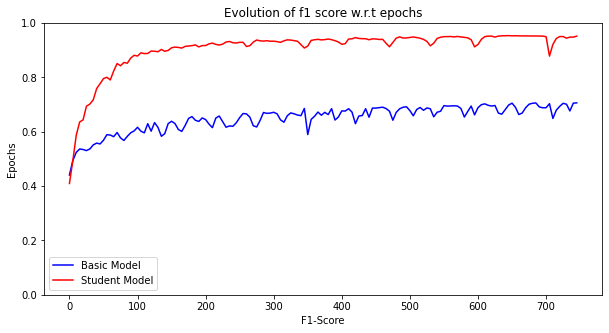

In [ ]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

def plot_f1_score(epoch_list, basic_model_scores, student_model_scores) :
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, basic_model_scores, 'b', label = "Basic Model")
    plt.plot(epoch_list, student_model_scores, 'r', label = "Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

(ANSWER)

The architecture proposed is replicated from the paper \it{Graph Attentional Network} published as a conference paper at ICLR 2018. Thee choice of this architecture is driven by the performances reached in the paper for the PPI dataset.

This architecture (GAT) has multiple advantages over GCN architextures, in terms of:

* **Expressivity.** First GATConv layer is able to compute more meaningful representation of input nodes. Indeed, GATConv use an attention mechanism to compute attention between a node and its neighborhood in order to compute some coefficients, and use them for representing the node as the sum of itself and is neighboorhood. As a result, the importance of each nodes of the neighborhood is different for each head attention and for each GATConv layer.
In GCNLayer the distribution coefficients are not learn, they are given by some operation on adjency matrix and degree matrix. Therefore, these coeffecients are fixed. The coefficients in GCNLayer are fixed and not learned. These coefficients are obtained through some operation on the adjacetncy matrix and degree matrix. GAT architecture's attention mechanism allows for the learning of attention coefficients, providing greater expressiveness.
* **Overcoming oversmoothing.** GATs address the limitations of GCNs, which rely on a fixed graph structure and suffer from oversmoothing, by using masked self-attentional layers that can handle varying graph structures and assign different importances to different nodes within a neighborhood.
* **Computational power.** Despite attention mechanism adds a  computation of specific coefficient for the neighborhood of each node, the function is highly parrallelisable and the time for computation remains in same order of magnitude as for GCN network with much more expressive functions. Along article, this could be linked to lesser matrix inversion and/or eigenvector decomposition. Moreover, improvements could be later achieved in using more efficiently GPU power along article.

Other avantages of the GAT not specifically used here, is that the attention mechanism, once learned, can be applied to graph which do not have the same structure as the ones used for training. Hence, it allows inductive resolution of problems. It leads to a better tractability of the results, and does not require the graph to be directed. 

The F1-Score is a widely employed measure to evaluate binary classification problems, wherein the said metric is calculated as the harmonic mean of precision and recall. The Formula reads:
$$score = 2 \frac{precision \times recall}{precision + recall},$$
with $$precision = \frac{true\ positives}{true\ positives+ false\ positives},$$
and 
$$recall = \frac{true\ positives}{true\ positives +false\ negatives}.$$

The resulting score ranges from 0 to 1, where higher values are indicative of superior performance.
Our algorithm achieves an F1-score of 0.9703, which is close to 1. The paper reports an F1-score of 0.973, indicating that we are approaching the state-of-the-art performance.

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ? 
2. Are there solutions to overcome it ? 
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

(ANSWER)

Oversmoothing occurs when the GNN model aggregates information from neighboring nodes through multiple iterations, causing the feature representations of the nodes to become increasingly similar. This makes it difficult for the model to differentiate between nodes and can lead to overgeneralization, which adversely affects the accuracy of the model's predictions. One of the main reasons why oversmoothing is a significant issue is that it can result in the GNN model producing overly confident predictions based on incomplete or incorrect information. This can lead to poor performance in downstream tasks and limit the applicability of GNNs in practical settings.

To combat oversmoothing, there has been various approaches proposed in the litterature such as adding skip connections, introducing regularization terms, and using hierarchical aggregation schemes. These methods aim to prevent feature representations from becoming too similar and to maintain the structural information in the graph, thereby improving the overall performance of GNNs.

The architecture incorporate those technics to mitigate oversmoothing:
* **Attention mechanism.** The GAT model is designed to assign different levels of importance to nodes within a neighborhood, making it less prone to oversmoothing compared to other GNN models that do not consider the distinctiveness of nodes.
* **Skip connections.** The architecture incorporates skip connections across the intermediate attentional layer. This is to mitigate the effects of oversmoothing and preserve the integrity of the graph. 
* **Hierarchical aggregation strategies.** The algorithm also uses hierarchical aggregation strategies, through multi-headed attention layer, which has been proposed to prevent oversmoothing by maintaining node identities and preserving the graph's structural coherence.